In [1]:
import pandas as pd
import numpy as np
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora
import seaborn as sns
import matplotlib.pylab as plt
from scipy.stats import pearsonr
from matplotlib.colors import ListedColormap
from scipy import stats as st
import matplotlib.colors as mcolors

In [17]:
file = pd.read_table('/home/janneae/cns/steps/featurefiles/discretized_10_0.7_5.features', dtype=str)
survivaldata = pd.read_table('/home/janneae/TCGA/DerivedData/TCGA_survival_data_clean.txt')
cin_loc = pd.read_table('../data/cin_locations.txt')
gene_exp = pd.read_table('../data/all_tcga_gene_exp.txt', sep='\t')
ascat = pd.read_table('/home/janneae/cns/data/filteredAscatRaw.txt', dtype=str)

In [3]:
df = file.drop(['Sample', 'Chr', 'GCcSeg'], axis = 1)
listedDf = df.values.tolist()
dirichlet_dict = corpora.Dictionary(listedDf)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in listedDf]

In [4]:
df.head()

,CN,SegSize,Dist2Cent,SegVal,LOH,SizeDipSeg,BpC,Dist2nCNV,NumRepeats
0,CN_3,SegSize_6,Dist2Cent_3,SegVal_4,LOH_0,SizeDipSeg_2,BpC_2,Dist2CNV_5,NumRepeats_5
1,CN_3,SegSize_5,Dist2Cent_4,SegVal_5,LOH_0,SizeDipSeg_1,BpC_4,Dist2CNV_2,NumRepeats_3
2,CN_3,SegSize_5,Dist2Cent_4,SegVal_2,LOH_0,SizeDipSeg_1,BpC_2,Dist2CNV_4,NumRepeats_4
3,CN_2,SegSize_6,Dist2Cent_2,SegVal_1,LOH_0,SizeDipSeg_3,BpC_2,Dist2CNV_2,NumRepeats_5
4,CN_2,SegSize_5,Dist2Cent_5,SegVal_2,LOH_0,SizeDipSeg_2,BpC_4,Dist2CNV_3,NumRepeats_2


## Tweaking parameters of LDA analysis

In [5]:
def create_heatmap(model, df, corpus):
    topics = model.get_document_topics(bow = corpus, minimum_probability = 0)
    
    new_df = pd.DataFrame(df['Sample'])
    new_df['Chr'] = df['Chr']
    new_df['Chr'] = pd.to_numeric(new_df['Chr'])
    
    columns = [[],[],[],[],[]]
    for topic in topics:
        for w in topic:
            columns[w[0]].append(w[1])
    
    new_df['1'] = columns[0]
    new_df['2'] = columns[1]
    new_df['3'] = columns[2]
    new_df['4'] = columns[3]
    new_df['5'] = columns[4]
    new_df = new_df.sort_values(by='Chr')
    return new_df

def correlate(cin, survival, val):
    gender = []
    age = []
    tel = []
    lst = []
    hrd = []
    hrd_score = []
    ploidy = []
    wGII = []
    wFLOH = []
    
    for i in range(1, 6):
        gender.append(pearsonr(survival[f'{i}'], survival['Gender'])[val])
        age.append(pearsonr(survival[f'{i}'], survival['Age_at_diagnosis'])[val])
        
        tel.append(pearsonr(cin[f'{i}'], cin['Telomeric.AI'])[val])
        lst.append(pearsonr(cin[f'{i}'], cin['lst'])[val])
        hrd.append(pearsonr(cin[f'{i}'], cin['hrd'])[val])
        hrd_score.append(pearsonr(cin[f'{i}'], cin['hrd_score'])[val])
        ploidy.append(pearsonr(cin[f'{i}'], cin['ploidy'])[val])
        wGII.append(pearsonr(cin[f'{i}'], cin['wGII'])[val])
        wFLOH.append(pearsonr(cin[f'{i}'], cin['wFLOH'])[val])

    
    corr_df = pd.DataFrame([1, 2, 3, 4, 5], columns=['Signature'])
    corr_df['Gender'] = gender
    corr_df['Age_at_diagnosis'] = age
    corr_df['Telomeric.AI'] = tel
    corr_df['LST'] = lst
    corr_df['HRD'] = hrd
    corr_df['HRD_score'] = hrd_score
    corr_df['Ploidy'] = ploidy
    corr_df['wGII'] = wGII
    corr_df['wFLOH'] = wFLOH

    corr_df = corr_df.set_index('Signature')
    # corr_df = corr_df.transpose()
    
    return corr_df

In [6]:
lda = LdaModel(
    corpus=bow_corpus,
    id2word=dirichlet_dict,
    num_topics=5,
    chunksize=len(bow_corpus),
    alpha='symmetric',
    eta='symmetric',
    random_state=42)

In [7]:
coherences = CoherenceModel(model=lda, corpus=bow_corpus, texts = listedDf, dictionary=dirichlet_dict, coherence='c_v', topn = 50).get_coherence()
coherences

0.3265685780533919

In [8]:
weights_df = weights_df = create_heatmap(lda, file, bow_corpus)
weights_df = weights_df[weights_df['Chr'] != 23]

In [9]:
gene_expT = gene_exp.transpose()
gene_expT['Sample'] = gene_expT.index

exp = weights_df.reset_index(drop=True).drop(['Chr'], axis = 1).drop_duplicates(subset = ["Sample"])
exp.columns = ['Sample', 'Sig1', 'Sig2', 'Sig3', 'Sig4', 'Sig5']
exp = pd.merge(left = exp, right = gene_expT, on = 'Sample')
exp.index = exp['Sample']
exp = exp.drop(['Sample'], axis = 1)
exp_final = exp.drop(['Sig1', 'Sig2', 'Sig3', 'Sig4', 'Sig5'], axis = 1)

cin_70 = list(cin_loc['Gene'])

cin70_expT = exp_final[exp_final.columns.intersection(cin_70)]
cin70_expT['mean'] = cin70_expT.mean(axis=1)

cin70_corr = []
cin70_pval = []

for signature in range(1, 6):
    cin70_corr.append(st.pearsonr(exp[f'Sig{signature}'], cin70_expT['mean'])[0])
    cin70_pval.append(st.pearsonr(exp[f'Sig{signature}'], cin70_expT['mean'])[1])

/scratch/1765133/ipykernel_34900/1381273015.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cin70_expT['mean'] = cin70_expT.mean(axis=1)


In [10]:
combined_df = weights_df.reset_index()
combined_df['Age_at_diagnosis'] = survivaldata['age_at_initial_pathologic_diagnosis']
combined_df['Gender'] = survivaldata['gender']
combined_df['Gender'] = pd.factorize(combined_df['Gender'])[0]
combined_df = combined_df.dropna()

cin = pd.read_table("../data/all_tcga_cin_measures.txt", sep=" ").set_index('sample_id').reindex(index=weights_df['Sample']).reset_index()
combined_cin = weights_df.reset_index()
combined_cin['Telomeric.AI'] = cin['Telomeric.AI']
combined_cin['lst'] = cin['lst']
combined_cin['hrd'] = cin['hrd']
combined_cin['wGII'] = cin['wGII']
combined_cin['ploidy'] = cin['Ploidy']
combined_cin['hrd_score'] = cin['lst'] + cin['Telomeric.AI'] + cin['hrd']
combined_cin['wFLOH'] = cin['wFLOH']
combined_cin = combined_cin.dropna()

corr_df = correlate(combined_cin, combined_df, 0)
corr_df['CIN70'] = cin70_corr
pval_df = correlate(combined_cin, combined_df, 1)
pval_df['CIN70'] = cin70_pval
corr_df = corr_df.transpose()
pval_df = pval_df.transpose()

In [11]:
alpha = 0.001/176000

for i in range(1, 5):
    for j in range(1, 7):
        if pval_df[i][j] > alpha:
            corr_df[i][j] = 0
corr_df

Signature,1,2,3,4,5
Gender,0.015320,-0.034498,-0.000563,0.005021,0.002904
Age_at_diagnosis,0.000000,0.000000,0.000000,0.000000,-0.012806
Telomeric.AI,0.320929,-0.083426,0.106397,-0.303462,-0.014165
LST,0.276812,-0.085711,0.073349,-0.257130,0.008934
HRD,0.221029,-0.085853,0.063779,-0.217145,0.028684
HRD_score,0.303306,-0.092107,0.090807,-0.287312,0.005539
Ploidy,0.117770,0.160095,0.172768,-0.268130,-0.095712
wGII,0.244060,-0.008352,0.158350,-0.306260,-0.037428
wFLOH,0.185168,-0.056514,0.096077,-0.214027,0.010579
CIN70,0.284112,-0.178121,0.038054,-0.295047,0.061689


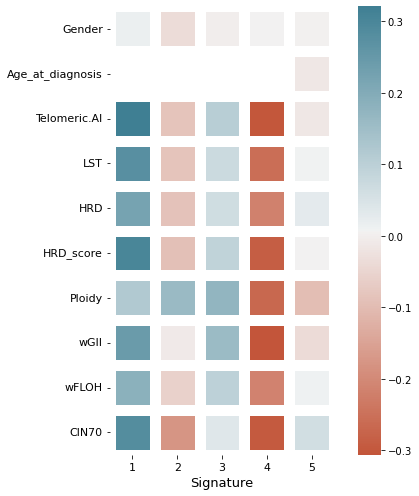

In [12]:
palette = sns.diverging_palette(20, 220, as_cmap=True)

f, ax = plt.subplots(figsize=(7, 7))
ax = sns.heatmap(
    corr_df[corr_df!=0],
    # vmin=-0.5, vmax=0.5, 
    cmap=palette,
    square=True,
    linewidths=11)
    
plt.xlabel("Signature", fontsize=13)
ax.tick_params(axis="both", labelsize=11)
f.tight_layout()
plt.savefig('../figures/correlation_matrix.pdf')

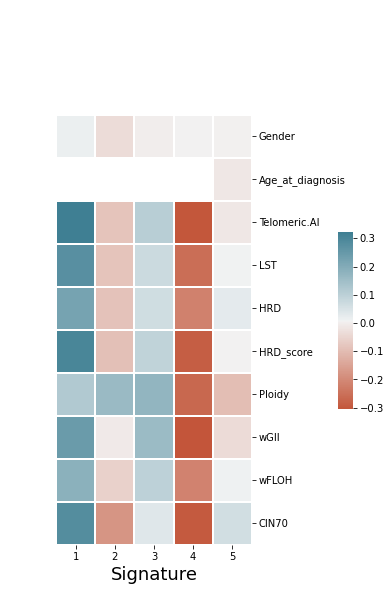

In [14]:
clustermap_df = corr_df
g = sns.clustermap(
    clustermap_df, cmap=palette, 
    cbar_pos=(0.95, .3, .04, .3),
    figsize=(5,8.2), linewidths=0.004,
    dendrogram_ratio=0.2, mask= clustermap_df==0,
    row_cluster=False, col_cluster=False
    # standard_scale=0
    )
# g.ax_heatmap.set_xlabel('Attribute', fontsize=15)
g.ax_heatmap.set_xlabel('Signature', fontsize=18)
g.savefig('../figures/cin_clustermap.pdf')

In [23]:
corr_df

Signature,1,2,3,4,5
Gender,-0.000504,-0.027603,-0.001835,0.005807,0.016307
Age_at_diagnosis,0.000000,0.000000,0.000000,0.000000,-0.003304
Telomeric.AI,0.099557,-0.176746,0.282908,-0.209585,0.024829
LST,0.064151,-0.166139,0.236561,-0.168642,0.043713
HRD,0.000000,-0.162693,0.207909,-0.130641,0.069523
HRD_score,0.069585,-0.183808,0.268177,-0.189564,0.046760
Ploidy,0.227111,0.100814,0.143220,-0.258688,-0.128989
wGII,0.142003,-0.093170,0.249344,-0.250994,-0.006396
wFLOH,0.010318,-0.139830,0.212765,-0.134118,0.050902
CIN70,0.100891,-0.206206,0.166232,-0.222284,0.092201
